# Demo: Bayes smoother

In [1]:
using LinearAlgebra
using Distributions
using ProgressMeter
using Random
using Plots
pyplot();

### Data

In [2]:
function LGDS(A,C,Q,R,prior_params; time_horizon=100)
    "Generate data according to a linear Gaussian dynamical system"

    # Dimensionality
    Dx = size(A,1)
    Dy = size(C,1)

    # Preallocate
    x = zeros(Dx, time_horizon)
    y = zeros(Dy, time_horizon)

    # Prior parameters
    mean0, var0 = prior_params
    
    # Previous variable
    x_kmin1 = mean0

    for k = 1:time_horizon

        # Evolve state
        x[:,k] = A*x_kmin1 .+ cholesky(Q).U*randn(Dx,) 

        # Observe
        y[:,k] = C*x[:,k] .+ cholesky(R).U*randn(Dy,)
        
        # Update previous state
        x_kmin1 = x[:,k]

    end
    return y, x
end;

In [3]:
# Time horizon
T = 500

# Dimensionalities
Dx = 2
Dy = 1

# Time step
Δt = 0.01

# Experimental parameters
A = [1. Δt;
     0  1.]
C = [1. 0]

# Noises
qc = 100.0
Q = [Δt^2*qc 0.;0. Δt*qc]
R = reshape([1.0], (1,1))

# Prior state
state0 = ([0., 0.], [1. 0.;0. 1.])

# Generate signal
observations, states = LGDS(A,C,Q,R,state0; time_horizon=T);

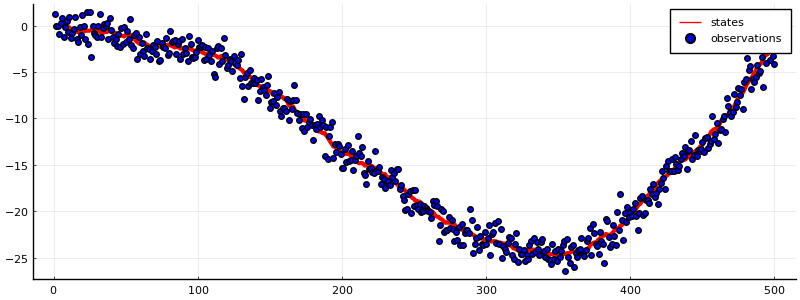

In [4]:
# Check signal visually
plot(1:T, states[1,:], linewidth=3, color="red", label="states", size=(800,300))
scatter!(1:T, observations[1,:], color="blue", label="observations")

### Model

### Inference

In [5]:
# Length of smoothing window
TT = 100

# Initialize estimate arrays
mk = zeros(Dx, T)
Pk = zeros(Dx, Dx, T)

# Initialize smoothing estimate arrays
msk = zeros(Dx, T)
Psk = zeros(Dx, Dx, T)

# Initial state prior
m_0, P_0 = state0

# Start previous state variable
m_kmin = m_0
P_kmin = P_0

# "Forward pass"
for k = 1:T

    # Forward prediction step
    m_k_pred = A*m_kmin
    P_k_pred = A*P_kmin*A' .+ Q

    # Forward update step
    v_k = observations[:,k] .- C*m_k_pred
    S_k = C*P_k_pred*C' .+ R
    K_k = P_k_pred*C'*inv(S_k)
    m_k = m_k_pred .+ K_k*v_k
    P_k = P_k_pred .- K_k*S_k*K_k'

    # Store estimates
    mk[:,k] = m_k
    Pk[:,:,k] = P_k

    # Update previous state variable
    m_kmin = m_k
    P_kmin = P_k
    
    # Smoothed estimates at time horizon
    msk[:,k] = mk[:,k]
    Psk[:,:,k] = Pk[:,:,k]
    
    if k > TT
        
        # "Backward pass"
        for k in range(T-1, step=-1, stop=T-TT)

            # Backward prediction
            m_kplus = A * mk[:,k]
            P_kplus = A * Pk[:,:,k] * A' .+ Q

            # Backward update step
            G_k = Pk[:,:,k]*A' * inv(P_kplus)
            msk[:,k] = mk[:,k] + G_k*(msk[:,k+1] - m_kplus)
            Psk[:,:,k] = Pk[:,:,k] + G_k*(Psk[:,:,k+1] - P_kplus)*G_k'

        end
    end
end

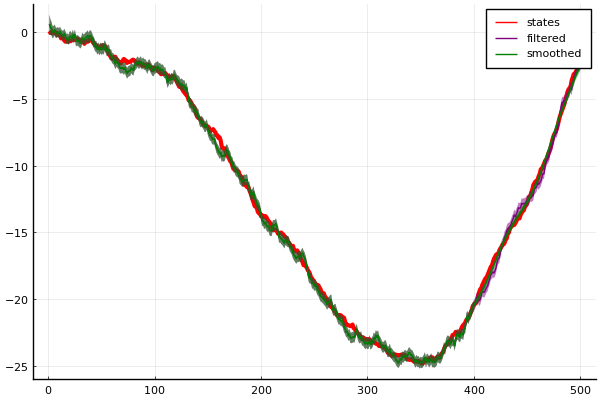

In [6]:
# Check signal visually
plot(1:T, states[1,:], linewidth=3, color="red", label="states")
# scatter!(1:T, observations[1,:], color="blue", label="observations")
plot!(1:T, mk[1,:], color="purple", label="filtered")
plot!(1:T, mk[1,:], ribbon=[sqrt.(Pk[1,1,:]), sqrt.(Pk[1,1,:])], alpha=0.1, color="purple", label="")
plot!(1:T, msk[1,:], color="green", label="smoothed")
plot!(1:T, msk[1,:], ribbon=[sqrt.(Psk[1,1,:]), sqrt.(Psk[1,1,:])], alpha=0.1, color="green", label="")